In [1]:
'''
Written by Jordan Van Nest (jdvannest@ou.edu)
April 2022, ASTR-3190
'''
import numpy as np
from math import pi
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
#Read in the data and assign columns to np arrays
ra,dec,run,Ar,u,g,r,i,z,uErr,gErr,rErr,iErr,zErr,pmL,pmB,pmErr = np.loadtxt('Astr511HW1data.dat.txt',unpack=True)

In [3]:
#Define Functions for finding M_r and Z

#Bond et al. 2010 (ApJ,716,1)
def Metallicity(x,y):
    #x=(u-g)   y=(g-r)
    assert len(x)==len(y), "u-g and g-r arrays must be same size"
    #Define Metallicity array with default value of -0.6
    Met = np.empty(len(x))
    Met[:] = -.6
    for i in np.arange(len(x)):
        #If g-r<.6, perform the metallicity calculation and update array
        if y[i]<.6:
            Met[i] = ((-13.13) + (14.09)*x[i] + (28.04)*y[i] + 
                     (-5.51)*x[i]*y[i] + (-5.9)*x[i]**2 + 
                     (-58.68)*y[i]**2 + (9.14)*y[i]*x[i]**2 +
                     (-20.61)*x[i]*y[i]**2 + (0)*x[i]**3 + 
                     (58.2)*y[i]**3)
    return Met

#Ivezic et al. 2008 (ApJ,684,287)
#Ivezic A2
def del_Mr(metallicity):
    return(4.5 - 1.11*metallicity - 0.18*metallicity**2 )
#Ivezic A7
def Mr0(g_i):
    return(-5.06 + 14.32*g_i - 12.97*g_i**2 +
           6.127*g_i**3 - 1.267*g_i**4 + 0.0967*g_i**5)
#Ivezic A3
def Mr(g_i,u_g,g_r):
    met = Metallicity(u_g,g_r)
    return(Mr0(g_i) + del_Mr(met))


def Z(r,Mr): #in units of pc
    return(10**((r-Mr)/5+1))

#math.stackexchange.com/questions/3032927/volume-inside-a-solid-solid-angle
def Vol(z):
    return((z**3/3)*(314*(pi/180)**2))
def DiffVol(z,dz):
    return((314*(pi/180)**2)*(z**2)*dz)

In [4]:
#Create arrays of Mr and Z values
mr = Mr(g-i,u-g,g-r)
z = Z(r,mr)

## Problem 1

In [65]:
#Define a function to calculate the ln(rho) profile for
#a given color range
def log_rho(z,g_r,min_color,max_color):
    #Pull out Z-values associated with stars in color range
    g_r_low_mask = g_r[g_r < max_color]
    Z_low_mask   = z[g_r < max_color]
    Z_masked     = Z_low_mask[g_r_low_mask > min_color]
    
    #Convert Z_masked to kpc
    Z_masked = Z_masked/1000

    #Create Z-bins and arrays to be plotted
    Z_bins = np.linspace(0,100,101)
    Z_axis = np.arange(max(Z_bins))+.5
    N,V    = [np.zeros(len(Z_axis)),np.zeros(len(Z_axis))]
    
    #Calculate Numbers and Volumes in each Z-bin
    for i in np.arange(len(Z_axis)):
        N[i] = len(Z_masked[(Z_masked > Z_bins[i]) & 
                            (Z_masked < Z_bins[i+1])])
        V[i] = Vol(Z_bins[i+1]) - Vol(Z_bins[i])
    
    #Remove any 0's for N before calculating NatLog
    N[N==0] = np.NaN
    
    return(Z_axis,np.log(N/V))

In [58]:
#Define a function to calculate the ln(rho) profile for
#a given color range
def log_rho_Nicole(z,g_r,min_color,max_color):
    #Pull out Z-values associated with stars in color range
    g_r_low_mask = g_r[g_r < max_color]
    Z_low_mask   = z[g_r < max_color]
    Z_masked     = Z_low_mask[g_r_low_mask > min_color]
    
    #Convert Z_masked to kpc
    Z_masked = Z_masked/1000
    
    #Create Z-bins and arrays to be plotted
    Z_bins = np.linspace(0,max(Z_masked),101)
    Z_axis = np.arange(max(Z_bins))+.5
    N,V    = [np.zeros(len(Z_axis)),np.zeros(len(Z_axis))]
    
    Z_step,dZ = 0,Z_bins[1]-Z_bins[0]
    #Calculate Numbers and Volumes in each Z-bin
    for i in np.arange(len(Z_axis)):
        if i==0:
            Z_step = Z_step + dZ
            dV_0   = (314*0.000304617)*(Z_step**2)*dZ
            dN_0   = len(Z_masked[Z_masked<Z_step])
            
            N[i] = dN_0
            V[i] = dV_0
        else:
            Z_step = Z_step + dZ
            dV_new = (314*0.000304617)*(Z_step**2)*dZ
            dN_new = len(Z_masked[Z_masked<Z_step])
            
            N[i] = dN_new - dN_0
            V[i] = dV_new - dV_0
            
            dN_0 = dN_new
            dV_0 = dV_new
    
    #Remove any 0's for N before calculating NatLog
    N[N==0] = np.NaN
    V[V==0] = np.NaN
    
    return(Z_axis,np.log(N/V))

In [63]:
#Perform ln(rho) calculation for .2 < g-r < .4
z_axis,rho = log_rho(z,g-r,.2,.4)
#z_axis,rho = log_rho_Nicole(z,g-r,.2,.4)

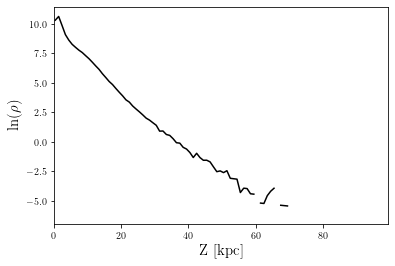

In [64]:
#Plot the results for .2 < g-r < .4
f,ax = plt.subplots(1,1,figsize=(6,4))
ax.set_xlim([0,max(z_axis)])
ax.set_xlabel('Z [kpc]',fontsize=15)
ax.set_ylabel(r'ln($\rho$)',fontsize=15)

ax.plot(z_axis,rho,c='k')

plt.show()

Discussion...

## Problem 2

In [10]:
#Repeat the process from Problem 1 for 
#new color ranges
z0,rho0 = log_rho(z,g-r,.2,.4)
z1,rho1 = log_rho(z,g-r,.4,.6)
z2,rho2 = log_rho(z,g-r,.6,.8)
z3,rho3 = log_rho(z,g-r,.8,1.)

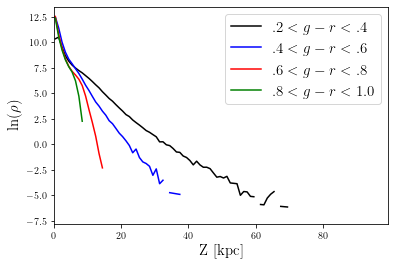

In [11]:
f,ax = plt.subplots(1,1,figsize=(6,4))
ax.set_xlim([0,max([max(z0),max(z1),max(z2),max(z3)])])
ax.set_xlabel('Z [kpc]',fontsize=15)
ax.set_ylabel(r'ln($\rho$)',fontsize=15)

ax.plot(z0,rho0,c='k',label=r'$.2<g-r<.4$')
ax.plot(z1,rho1,c='b',label=r'$.4<g-r<.6$')
ax.plot(z2,rho2,c='r',label=r'$.6<g-r<.8$')
ax.plot(z3,rho3,c='g',label=r'$.8<g-r<1.0$')

ax.legend(loc='upper right',prop={'size':15})
plt.show()

Discussion...

## Problem 3

In [12]:
#Create Low-Met and High-Met Masks
Low_Met = (Metallicity(u-g,g-r) < -1.)
High_Met = (Metallicity(u-g,g-r) > -1.)

In [13]:
#Perform ln(rho) calculation on low and high-met subsamples
z_low,rho_low = log_rho(z[Low_Met],(g-r)[Low_Met],.2,.4)
z_high,rho_high = log_rho(z[High_Met],(g-r)[High_Met],.2,.4)

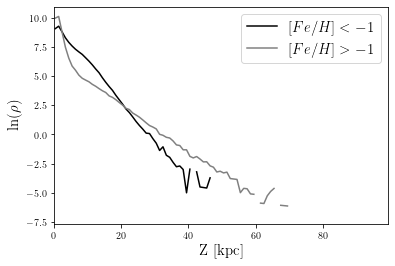

In [14]:
f,ax = plt.subplots(1,1,figsize=(6,4))
ax.set_xlim([0,max(z_high)])
ax.set_xlabel('Z [kpc]',fontsize=15)
ax.set_ylabel(r'ln($\rho$)',fontsize=15)

ax.plot(z_low,rho_low,c='k',label=r'$[Fe/H]<-1$')
ax.plot(z_high,rho_high,c='.5',label=r'$[Fe/H]>-1$')

ax.legend(loc='upper right',prop={'size':15})
plt.show()

Discussion...

## Problem 4

In [15]:
#Define a function to pull out Mr values of stars in
#a given color range
def Mr_subset(mr,g_r,min_color,max_color):
    g_r_low_mask = g_r[g_r < max_color]
    Mr_low_mask = mr[g_r < max_color]
    Mr_masked = Mr_low_mask[g_r_low_mask > min_color]
    
    return(Mr_masked)

In [16]:
#Find the Mr values for the low and high-met subsets
Mr_Low  = Mr_subset(mr[Low_Met],(g-r)[Low_Met],.2,.4)
Mr_High = Mr_subset(mr[High_Met],(g-r)[High_Met],.2,.4)
Mr_Tot  = Mr_subset(mr,(g-r),.2,.4)

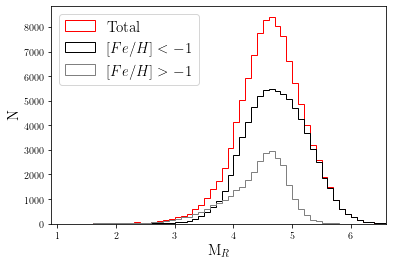

In [17]:
Mr_min  = min([min(Mr_Low),min(Mr_High)])
Mr_max  = max([max(Mr_Low),max(Mr_High)])
Mr_bins = np.arange((int(Mr_min*10)-1)/10,(int(Mr_max*10)+1)/10,.1)

f,ax = plt.subplots(1,1,figsize=(6,4))
ax.set_xlim([min(Mr_bins),max(Mr_bins)])
ax.set_xlabel(r'M$_R$',fontsize=15)
ax.set_ylabel('N',fontsize=15)

ax.hist(Mr_Tot,Mr_bins,color='r',histtype='step',label='Total')
ax.hist(Mr_Low,Mr_bins,color='k',histtype='step',label=r'$[Fe/H]<-1$')
ax.hist(Mr_High,Mr_bins,color='.5',histtype='step',label=r'$[Fe/H]>-1$')

ax.legend(loc='upper left',prop={'size':15})
plt.show()

Discussion...

## Problem 5